In [ ]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

import numpy as np

import os
from PIL import Image
from dataclasses import dataclass
from tqdm.notebook import tqdm

In [15]:
@dataclass
class TrainingConfig:
    image_size = 32
    train_batch_size = 64
    eval_batch_size = 64
    num_epochs = 20
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 10
    output_dir = "ddpm_mnist"
    seed = 0

config = TrainingConfig()
os.makedirs(config.output_dir, exist_ok=True)

In [10]:
def get_mnist_dataloader(image_size, batch_size):
    """Loads the MNIST dataset."""
    preprocess = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # (pixel - 0.5) / 0.5
        ]
    )

    dataset = torchvision.datasets.MNIST(
        root="./data", train=True, download=True, transform=preprocess
    )

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [1]:
import torch
import torch.nn as nn
from diffusers import UNet2DModel

class KoopmanUNet(nn.Module):
    def __init__(self, unet_model):
        """
        Initializes the KoopmanUNet from a pre-trained UNet2DModel.
        """
        super().__init__()
        
        # use same UNet components
        self.time_proj = unet_model.time_proj
        self.time_embedding = unet_model.time_embedding
        self.down_blocks = unet_model.down_blocks
        self.mid_block = unet_model.mid_block  # Don't forget the middle!
        self.up_blocks = unet_model.up_blocks
        self.conv_norm_out = unet_model.conv_norm_out
        self.conv_act = unet_model.conv_act
        self.conv_out = unet_model.conv_out
        
        self.bottleneck_c = unet_model.config.block_out_channels[-1]
        num_down_blocks = len(unet_model.down_blocks)
        downsample_factor = 2 ** num_down_blocks
        self.bottleneck_h = unet_model.config.sample_size // downsample_factor
        self.bottleneck_w = unet_model.config.sample_size // downsample_factor
        self.bottleneck_features = self.bottleneck_c * self.bottleneck_h * self.bottleneck_w
        
        # koopman operator
        # $z_0 \approx K \cdot z_t$
        self.koopman_operator = nn.Linear(self.bottleneck_features, self.bottleneck_features)
    
    def forward(self, x, t):
        """
        Forward pass with Koopman operator at the bottleneck.
        """
        batch_size = x.shape[0]
        
        t_emb = self.time_embedding(self.time_proj(t))
        
        skip_connections = []
        for block in self.down_blocks:
            x, skips = block(x, t_emb)
            skip_connections.append(skips)
        
        x = self.mid_block(x, t_emb)
        
        x_flat = x.view(batch_size, -1)
        # apply Koopman operator
        x_flat = self.koopman_operator(x_flat)
        
        # reshape back
        x = x_flat.view(batch_size, self.bottleneck_c, self.bottleneck_h, self.bottleneck_w)
        
        for block in self.up_blocks:
            # Pop skip connections in reverse order (they were added in forward order)
            skips = skip_connections.pop()
            x = block(x, skips, t_emb)
        
        x = self.conv_norm_out(x)
        x = self.conv_act(x)
        x = self.conv_out(x)
        
        return (x,) # we have to return like this as it has to match diffusers format

KeyboardInterrupt: 

In [11]:
def setup_model_and_scheduler(image_size, koopman=False):
    """Initializes the U-Net model and noise scheduler."""
    model = UNet2DModel(
        sample_size=image_size,
        in_channels=1,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(32, 64, 128, 128),
        down_block_types=(
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "AttnUpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
        ),
    )
    if koopman:
        model = Koo
    noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
    return model, noise_scheduler

In [12]:
def tensor_to_pil(image_tensor):
    """Converts a tensor image to a PIL Image."""
    image = (image_tensor / 2 + 0.5).clamp(0, 1) # Denormalize from [-1, 1] to [0, 1]
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(img.squeeze(), 'L') for img in images]
    return pil_images

def generate_and_save_images(model, scheduler, epoch, config):
    """Generates images and saves them to a file."""
    print(f"Generating images for epoch {epoch+1}...")
    model.eval()
    pipeline = DDPMPipeline(unet=model, scheduler=scheduler)

    # generate a batch of images
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    image_grid = torchvision.utils.make_grid(
        [transforms.ToTensor()(img) for img in images], nrow=8
    )

    pil_grid = transforms.ToPILImage()(image_grid)
    save_path = os.path.join(config.output_dir, f"epoch_{epoch+1:04d}.png")
    pil_grid.save(save_path)
    print(f"Saved image grid to {save_path}")

    display(pil_grid)

In [16]:
def train_loop(config, model, noise_scheduler, optimizer, lr_scheduler, train_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"--- Starting Training on {device} ---")

    for epoch in range(config.num_epochs):
        model.train()  
        progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{config.num_epochs}")
        epoch_loss = 0.0

        for step, (images, _) in enumerate(train_dataloader):
            clean_images = images.to(device)
            batch_size = clean_images.shape[0]

            # sample random noise and timesteps
            noise = torch.randn_like(clean_images)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

            # add noise to the clean images (the "forward process")
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # get the model's prediction for the noise
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            # 8. Update progress bar
            epoch_loss += loss.item()
            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())

        progress_bar.close()
        print(f"Epoch {epoch+1} Average Loss: {epoch_loss / len(train_dataloader)}")

        # --- 5. Save Images and Model Checkpoint ---
        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            generate_and_save_images(model, noise_scheduler, epoch, config)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            model_path = os.path.join(config.output_dir, "unet_model")
            model.save_pretrained(model_path)
            print(f"Saved model to {model_path}")

--- Starting Training on cuda ---


Epoch 1/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 Average Loss: 0.16764148042551172


Epoch 2/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 Average Loss: 0.030862654005286535


Epoch 3/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 Average Loss: 0.025538798159500685


Epoch 4/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 Average Loss: 0.023163324216011364


Epoch 5/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 Average Loss: 0.021657343277695782
Generating images for epoch 5...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist/epoch_0005.png


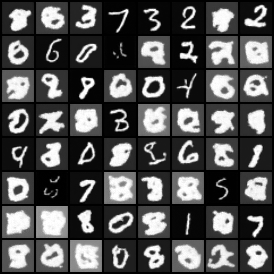

Epoch 6/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 Average Loss: 0.02054615371894322


Epoch 7/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 Average Loss: 0.019635282495597213


Epoch 8/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 Average Loss: 0.018872523803446593


Epoch 9/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 Average Loss: 0.01831131186713574


Epoch 10/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 Average Loss: 0.017777724353386076
Generating images for epoch 10...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist/epoch_0010.png


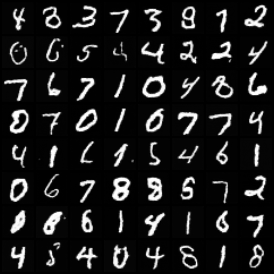

Saved model to ddpm_mnist/unet_model


Epoch 11/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11 Average Loss: 0.017247560536310172


Epoch 12/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12 Average Loss: 0.016859254524755136


Epoch 13/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13 Average Loss: 0.0165490551925163


Epoch 14/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14 Average Loss: 0.016491364498040888


Epoch 15/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15 Average Loss: 0.016336774209271997
Generating images for epoch 15...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist/epoch_0015.png


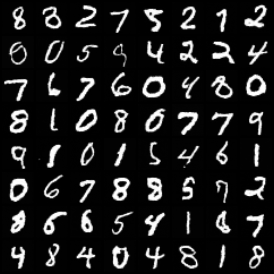

Epoch 16/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16 Average Loss: 0.01604778659956923


Epoch 17/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17 Average Loss: 0.01582843995442602


Epoch 18/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18 Average Loss: 0.015709925558108257


Epoch 19/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19 Average Loss: 0.015787920820266643


Epoch 20/20:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20 Average Loss: 0.015806169775344416
Generating images for epoch 20...


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved image grid to ddpm_mnist/epoch_0020.png


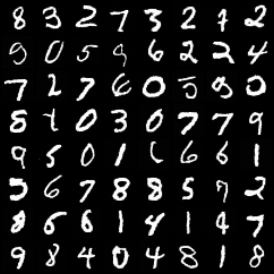

Saved model to ddpm_mnist/unet_model


In [17]:
train_dataloader = get_mnist_dataloader(config.image_size, config.train_batch_size)

model, noise_scheduler = setup_model_and_scheduler(config.image_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

train_loop(config, model, noise_scheduler, optimizer, lr_scheduler, train_dataloader)